## Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import urllib.request
import seaborn as sns
from sklearn.metrics import mean_squared_error

## Question 5: Matrix Factorization for Recommendation Systems

### Set random seed for reproducibility

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("QUESTION 5: MATRIX FACTORIZATION FOR RECOMMENDATION SYSTEMS")
print("="*60)

QUESTION 5: MATRIX FACTORIZATION FOR RECOMMENDATION SYSTEMS


### Part (a): Understanding the Problem

In [4]:
# Part (a): Understanding the Problem
print("\n" + "="*50)
print("PART (a): Understanding the Problem")
print("="*50)

m, n, k = 1000, 500, 10
observed_ratio = 0.20

num_observed = int(observed_ratio * m * n)
num_params_U = m * k
num_params_V = n * k
total_params = num_params_U + num_params_V
obs_to_param_ratio = num_observed / total_params

print(f"Number of users (m): {m}")
print(f"Number of movies (n): {n}")
print(f"Latent features (k): {k}")
print(f"Observation ratio: {observed_ratio}")
print(f"Number of observed ratings: {num_observed:,}")
print(f"Parameters in U: {num_params_U:,}")
print(f"Parameters in V: {num_params_V:,}")
print(f"Total parameters: {total_params:,}")
print(f"Observations to parameters ratio: {obs_to_param_ratio:.2f}")


PART (a): Understanding the Problem
Number of users (m): 1000
Number of movies (n): 500
Latent features (k): 10
Observation ratio: 0.2
Number of observed ratings: 100,000
Parameters in U: 10,000
Parameters in V: 5,000
Total parameters: 15,000
Observations to parameters ratio: 6.67


### Part (b): Synthetic Data Generation

In [5]:
# Part (b): Synthetic Data Generation
print("\n" + "="*50)
print("PART (b): Synthetic Data Generation")
print("="*50)

# Step 1: Create ground truth matrices
m_synth, n_synth, k_true = 100, 50, 5
print(f"Creating synthetic data: {m_synth} users, {n_synth} movies, {k_true} latent features")

U_true = np.random.normal(0, 1, (m_synth, k_true))
V_true = np.random.normal(0, 1, (n_synth, k_true))
R_true = U_true @ V_true.T

print(f"U_true shape: {U_true.shape}")
print(f"V_true shape: {V_true.shape}")
print(f"R_true shape: {R_true.shape}")
print(f"R_true range before scaling: [{R_true.min():.3f}, {R_true.max():.3f}]")

# Step 2: Scale ratings to [1, 5]
R_true_min = R_true.min()
R_true_max = R_true.max()
R_true = 1 + 4 * (R_true - R_true_min) / (R_true_max - R_true_min)

print(f"R_true range after scaling: [{R_true.min():.3f}, {R_true.max():.3f}]")

# Step 3: Create observed matrix with 70% missing
mask_ratio = 0.70
M = np.random.random(R_true.shape) > mask_ratio  # 30% observed
R_obs = R_true * M

print(f"Observation mask shape: {M.shape}")
print(f"Number of observed ratings: {np.sum(M)}")
print(f"Observation percentage: {100 * np.sum(M) / (m_synth * n_synth):.1f}%")

# Step 4: Split into training and test sets
observed_indices = np.where(M)
num_observed_total = len(observed_indices[0])
num_train = int(0.8 * num_observed_total)

# Shuffle observed indices
shuffled_idx = np.random.permutation(num_observed_total)
train_idx = shuffled_idx[:num_train]
test_idx = shuffled_idx[num_train:]

# Create train and test masks
M_train = np.zeros_like(M, dtype=bool)
M_test = np.zeros_like(M, dtype=bool)

train_users, train_movies = observed_indices[0][train_idx], observed_indices[1][train_idx]
test_users, test_movies = observed_indices[0][test_idx], observed_indices[1][test_idx]

M_train[train_users, train_movies] = True
M_test[test_users, test_movies] = True

R_train = R_true * M_train
R_test_mask = R_true * M_test

print(f"Training ratings: {np.sum(M_train)}")
print(f"Test ratings: {np.sum(M_test)}")
print(f"Train/Test split: {100 * np.sum(M_train) / num_observed_total:.1f}% / {100 * np.sum(M_test) / num_observed_total:.1f}%")


PART (b): Synthetic Data Generation
Creating synthetic data: 100 users, 50 movies, 5 latent features
U_true shape: (100, 5)
V_true shape: (50, 5)
R_true shape: (100, 50)
R_true range before scaling: [-9.873, 8.782]
R_true range after scaling: [1.000, 5.000]
Observation mask shape: (100, 50)
Number of observed ratings: 1471
Observation percentage: 29.4%
Training ratings: 1176
Test ratings: 295
Train/Test split: 79.9% / 20.1%


### Part (c): Manual Simple Matrix Factorization using SVD by Hand

In [6]:
# Part (c): Simple Matrix Factorization using Manual SVD
print("\n" + "="*50)
print("PART (c): Simple Matrix Factorization using Manual SVD")
print("="*50)

# Replace missing values with 0 for SVD
R_obs_zeros = R_obs.copy()
R_obs_zeros[~M] = 0

# Manual SVD implementation with improved numerical stability
def compute_svd_manual(A):
    """Compute SVD manually without using np.linalg.svd"""
    # Ensure we work with real numbers only
    A = A.astype(np.float64)
    
    # Compute A^T * A
    AtA = A.T @ A
    
    # Compute eigenvalues and eigenvectors of A^T * A
    eigenvalues, V = np.linalg.eig(AtA)
    
    # Take only real parts to avoid complex numbers due to numerical errors
    eigenvalues = np.real(eigenvalues)
    V = np.real(V)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]
    
    # Ensure non-negative eigenvalues (avoid small negative values due to numerical errors)
    eigenvalues = np.maximum(eigenvalues, 0)
    
    # Compute singular values
    singular_values = np.sqrt(eigenvalues)
    
    # Compute U matrix
    U = np.zeros((A.shape[0], A.shape[0]))
    rank = min(A.shape[0], A.shape[1])
    
    for i in range(rank):
        if singular_values[i] > 1e-10:  # Avoid division by zero
            U[:, i] = (A @ V[:, i]) / singular_values[i]
        else:
            # For zero singular values, use a unit vector orthogonal to others
            U[:, i] = np.random.randn(A.shape[0])
            for j in range(i):
                U[:, i] -= np.dot(U[:, i], U[:, j]) * U[:, j]
            U[:, i] /= np.linalg.norm(U[:, i])
    
    # Fill remaining columns of U with orthonormal vectors
    if A.shape[0] > rank:
        for i in range(rank, A.shape[0]):
            U[:, i] = np.random.randn(A.shape[0])
            for j in range(i):
                U[:, i] -= np.dot(U[:, i], U[:, j]) * U[:, j]
            U[:, i] /= np.linalg.norm(U[:, i])
    
    return U, singular_values, V.T

# Compute SVD manually
U, s, Vt = compute_svd_manual(R_obs_zeros)
print(f"SVD computed: U shape {U.shape}, s shape {s.shape}, Vt shape {Vt.shape}")

# Rank-k approximation for k = 5
k_svd = 5
U_k = U[:, :k_svd]
s_k = s[:k_svd]
Vt_k = Vt[:k_svd, :]

Sigma_k = np.diag(s_k)
R_approx = U_k @ Sigma_k @ Vt_k

# Clip to valid rating range
R_approx = np.clip(R_approx, 1, 5)

print(f"Rank-{k_svd} approximation computed")
print(f"R_approx shape: {R_approx.shape}")
print(f"R_approx range: [{R_approx.min():.3f}, {R_approx.max():.3f}]")

# Evaluate performance
def calculate_rmse(true_ratings, pred_ratings, mask):
    """Calculate RMSE for observed ratings under given mask"""
    observed_true = true_ratings[mask]
    observed_pred = pred_ratings[mask]
    mse = mean_squared_error(observed_true, observed_pred)
    return np.sqrt(mse)

train_rmse = calculate_rmse(R_true, R_approx, M_train)
test_rmse = calculate_rmse(R_true, R_approx, M_test)

print(f"Training RMSE (k={k_svd}): {train_rmse:.4f}")
print(f"Test RMSE (k={k_svd}): {test_rmse:.4f}")


PART (c): Simple Matrix Factorization using Manual SVD
SVD computed: U shape (100, 100), s shape (50,), Vt shape (50, 50)
Rank-5 approximation computed
R_approx shape: (100, 50)
R_approx range: [1.000, 3.608]
Training RMSE (k=5): 1.7312
Test RMSE (k=5): 1.7922


### Part (d): Visualization and Analysis


PART (d): Visualization and Analysis


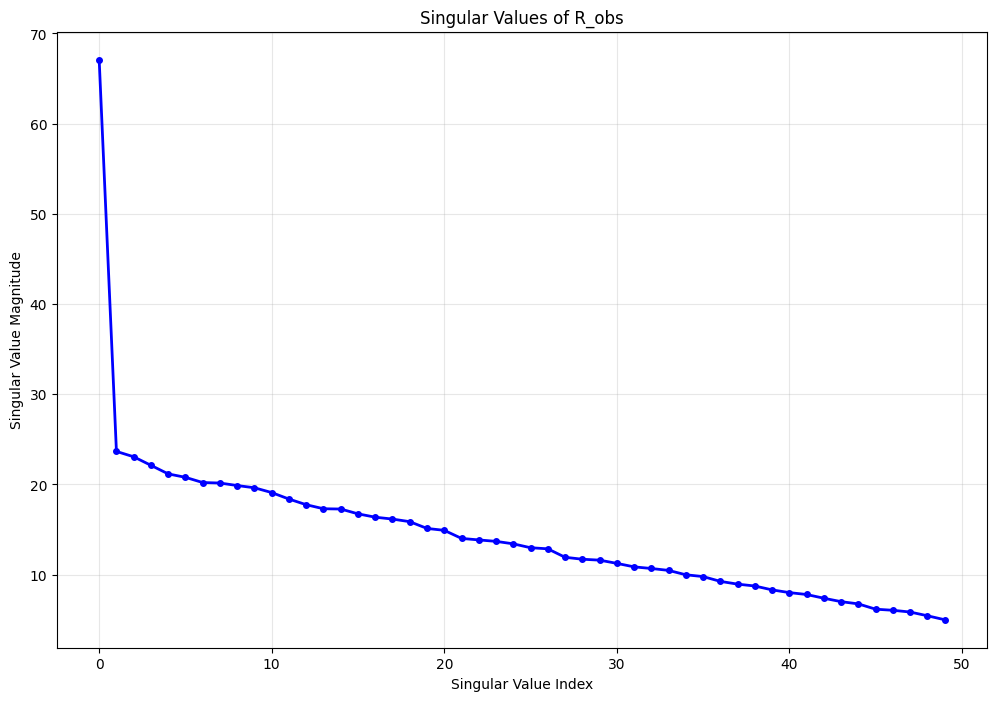

In [7]:
print("\n" + "="*50)
print("PART (d): Visualization and Analysis")
print("="*50)

# Step 1: Plot singular values
plt.figure(figsize=(12, 8))

# plt.subplot(2, 3, 1)
plt.plot(s, 'bo-', linewidth=2, markersize=4)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.title('Singular Values of R_obs')
plt.grid(True, alpha=0.3)

### Calculate cumulative energy

Singular value analysis:
  σ_1: 67.083 (30.8%, cum: 30.8%)
  σ_2: 23.665 (3.8%, cum: 34.6%)
  σ_3: 23.070 (3.6%, cum: 38.3%)
  σ_4: 22.123 (3.4%, cum: 41.6%)
  σ_5: 21.173 (3.1%, cum: 44.7%)
  σ_6: 20.793 (3.0%, cum: 47.7%)
  σ_7: 20.214 (2.8%, cum: 50.5%)
  σ_8: 20.160 (2.8%, cum: 53.2%)
  σ_9: 19.882 (2.7%, cum: 55.9%)
  σ_10: 19.635 (2.6%, cum: 58.6%)


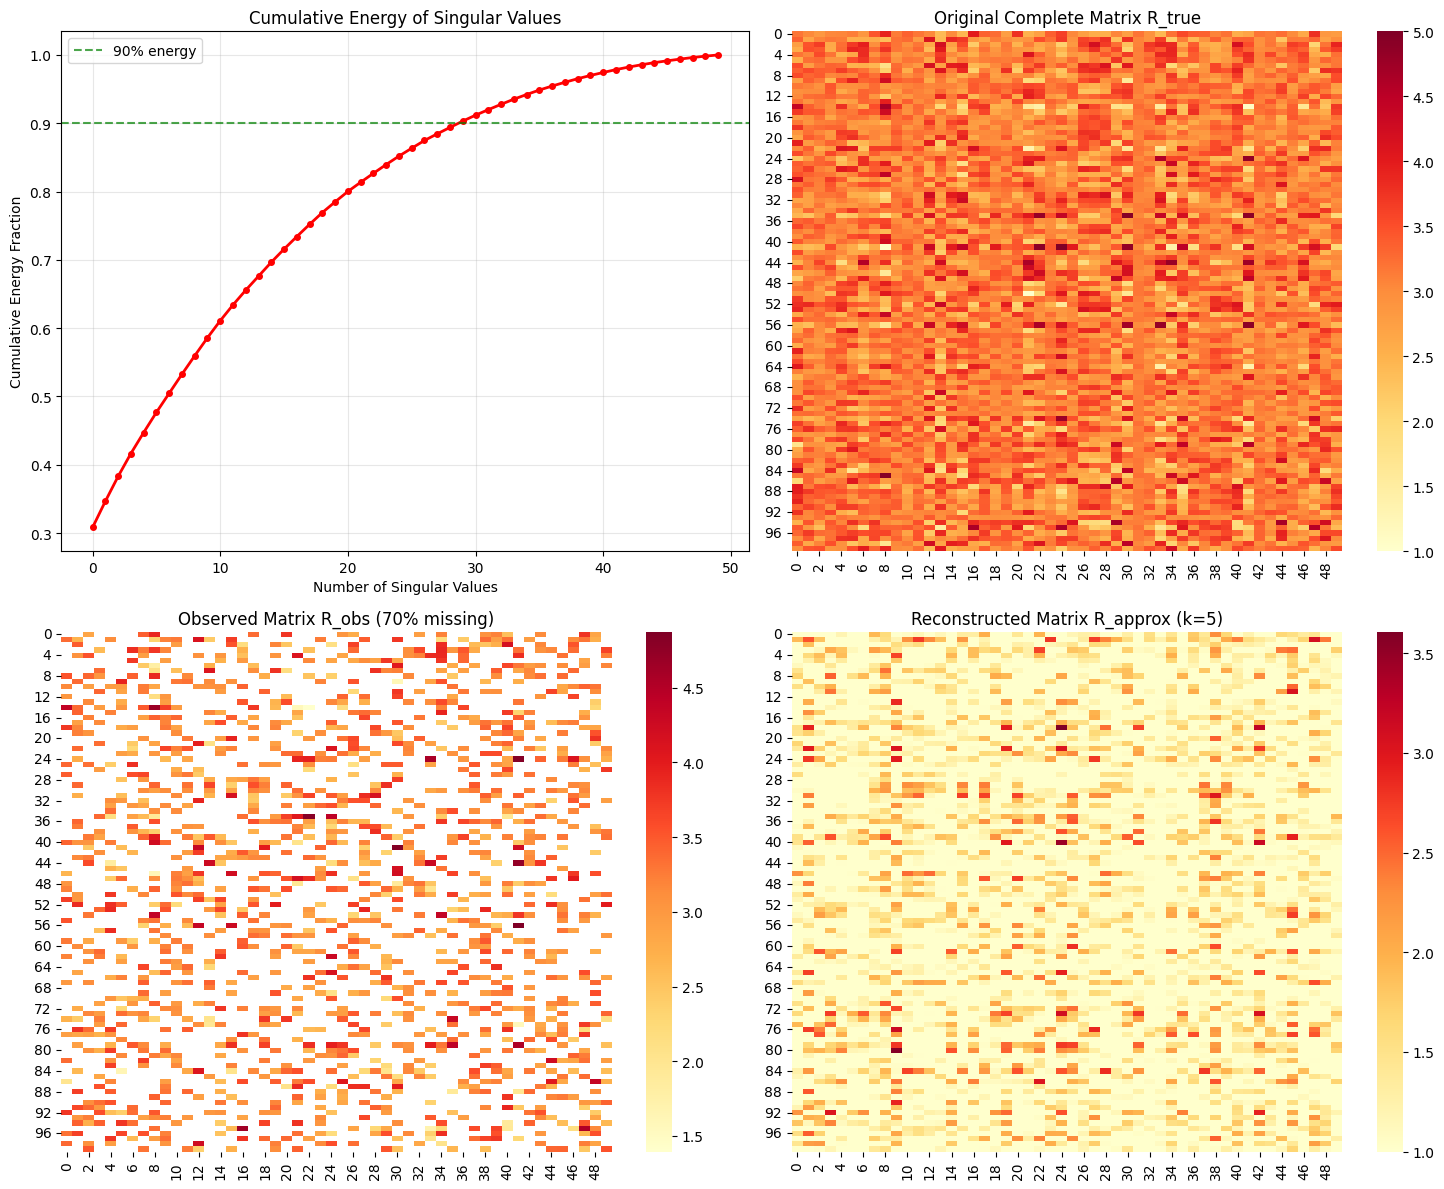


RMSE for different k values:
k	Train RMSE	Test RMSE
------------------------------
1	2.0691		2.1050
2	1.9720		1.9918
3	1.8830		1.9243
5	1.7312		1.7922
10	1.4178		1.4839
20	0.9435		0.9688


In [8]:
# Calculate cumulative energy and visualize matrices
cumulative_energy = np.cumsum(s**2) / np.sum(s**2)
plt.figure(figsize=(15, 12))

# Subplot 1: cumulative energy curve
plt.subplot(2, 2, 1)
plt.plot(cumulative_energy, 'ro-', linewidth=2, markersize=4)
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Energy Fraction')
plt.title('Cumulative Energy of Singular Values')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% energy')
plt.legend()

print("Singular value analysis:")
total_energy = np.sum(s**2)
for i in range(min(10, len(s))):
    energy_frac = (s[i]**2) / total_energy
    cum_energy = cumulative_energy[i]
    print(f"  σ_{i+1}: {s[i]:.3f} ({100*energy_frac:.1f}%, cum: {100*cum_energy:.1f}%)")

# Subplot 2: original complete matrix
plt.subplot(2, 2, 2)
sns.heatmap(R_true, cmap='YlOrRd', cbar=True)
plt.title('Original Complete Matrix R_true')

# Subplot 3: observed matrix with missing values
plt.subplot(2, 2, 3)
masked_data = R_obs.copy()
masked_data[~M] = np.nan
sns.heatmap(masked_data, cmap='YlOrRd', cbar=True)
plt.title('Observed Matrix R_obs (70% missing)')

# Subplot 4: reconstructed matrix
plt.subplot(2, 2, 4)
sns.heatmap(R_approx, cmap='YlOrRd', cbar=True)
plt.title(f'Reconstructed Matrix R_approx (k={k_svd})')

plt.tight_layout()
plt.show()

# Step 3: RMSE for different k values
k_values = [1, 2, 3, 5, 10, 20]
train_rmses = []
test_rmses = []

print("\nRMSE for different k values:")
print("k\tTrain RMSE\tTest RMSE")
print("-" * 30)

for k in k_values:
    # Rank-k approximation using manual SVD
    U_k = U[:, :k]
    s_k = s[:k]
    Vt_k = Vt[:k, :]
    Sigma_k = np.diag(s_k)
    R_approx_k = U_k @ Sigma_k @ Vt_k
    R_approx_k = np.clip(R_approx_k, 1, 5)
    
    train_rmse_k = calculate_rmse(R_true, R_approx_k, M_train)
    test_rmse_k = calculate_rmse(R_true, R_approx_k, M_test)
    
    train_rmses.append(train_rmse_k)
    test_rmses.append(test_rmse_k)
    
    print(f"{k}\t{train_rmse_k:.4f}\t\t{test_rmse_k:.4f}")

### Plot RMSE vs k

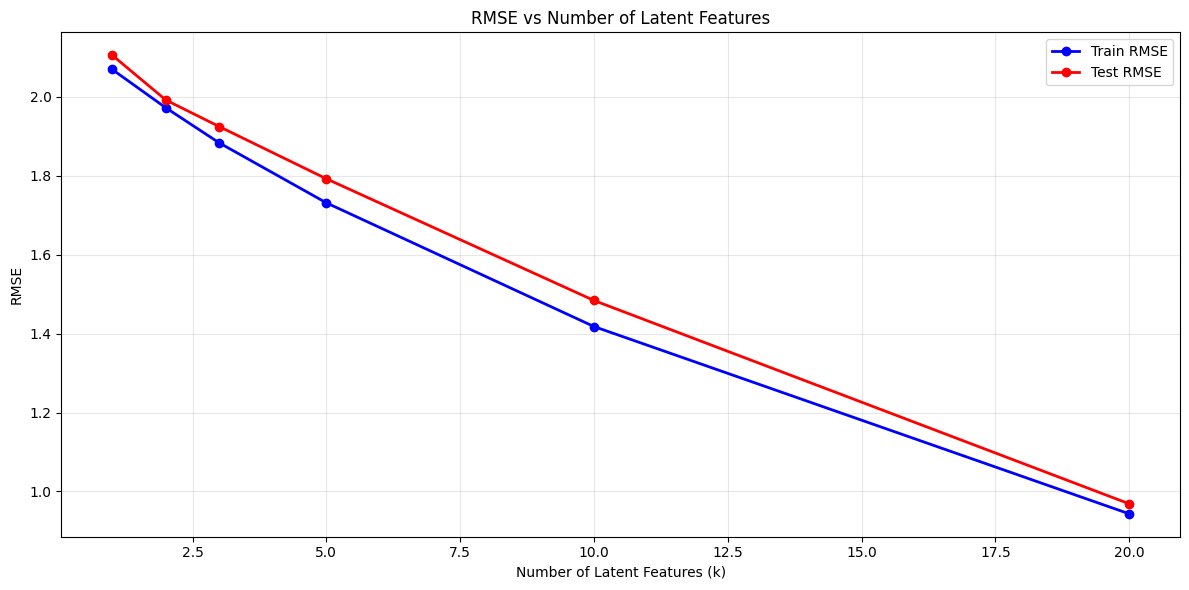

In [9]:
# Plot RMSE vs k
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_rmses, 'bo-', linewidth=2, markersize=6, label='Train RMSE')
plt.plot(k_values, test_rmses, 'ro-', linewidth=2, markersize=6, label='Test RMSE')
plt.xlabel('Number of Latent Features (k)')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Latent Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 4: Optimal k selection

In [10]:
# Step 4: Optimal k selection
optimal_k_idx = np.argmin(test_rmses)
optimal_k = k_values[optimal_k_idx]
optimal_test_rmse = test_rmses[optimal_k_idx]

print(f"\nOptimal k selection analysis:")
print(f"Best test performance at k = {optimal_k} (RMSE = {optimal_test_rmse:.4f})")
print("\nBias-Variance Tradeoff:")
print(f"- k = 1-3: High bias (underfitting), both train and test RMSE are high")
print(f"- k = {optimal_k}: Good balance, test RMSE minimized")
print(f"- k = 10-20: Increasing variance (overfitting), train RMSE decreases but test RMSE increases")

# Additional analysis: Compare with ground truth SVD
print("\n" + "="*50)
print("ADDITIONAL ANALYSIS: Comparison with Ground Truth")
print("="*50)

# Manual SVD on complete ground truth matrix
U_true_svd, s_true, Vt_true_svd = compute_svd_manual(R_true)
print(f"Ground truth singular values (first 10): {s_true[:10]}")

# Best possible reconstruction error
R_approx_best = U_true_svd[:, :optimal_k] @ np.diag(s_true[:optimal_k]) @ Vt_true_svd[:optimal_k, :]
# Ensure the result is real-valued
R_approx_best = np.real(R_approx_best)
best_rmse = calculate_rmse(R_true, R_approx_best, M_test)
print(f"Best possible test RMSE (with complete data): {best_rmse:.4f}")
print(f"Our method achieved: {test_rmses[optimal_k_idx]:.4f}")
print(f"Performance gap: {test_rmses[optimal_k_idx] - best_rmse:.4f}")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("Observations from matrix factorization for recommendation systems:")
print("1. Manual SVD on zero-filled matrix provides a reasonable baseline but is suboptimal")
print("2. The singular value spectrum reveals intrinsic dimensionality of the data")
print("3. Optimal k balances bias and variance in the bias-variance tradeoff")
print("4. Matrix factorization effectively captures latent user and movie features")
print("5. Proper handling of missing values is crucial for good performance")


Optimal k selection analysis:
Best test performance at k = 20 (RMSE = 0.9688)

Bias-Variance Tradeoff:
- k = 1-3: High bias (underfitting), both train and test RMSE are high
- k = 20: Good balance, test RMSE minimized
- k = 10-20: Increasing variance (overfitting), train RMSE decreases but test RMSE increases

ADDITIONAL ANALYSIS: Comparison with Ground Truth
Ground truth singular values (first 10): [2.20060608e+02 1.89890378e+01 1.64635104e+01 1.46580952e+01
 1.11865078e+01 9.89958302e+00 1.78012343e-06 1.61790210e-06
 1.61790210e-06 1.54504578e-06]
Best possible test RMSE (with complete data): 0.0000
Our method achieved: 0.9688
Performance gap: 0.9688

CONCLUSION
Observations from matrix factorization for recommendation systems:
1. Manual SVD on zero-filled matrix provides a reasonable baseline but is suboptimal
2. The singular value spectrum reveals intrinsic dimensionality of the data
3. Optimal k balances bias and variance in the bias-variance tradeoff
4. Matrix factorization eff